## The Battle of Neighbourhood’s
#### Identifying the similarity (or dissimilarity) between Neighbourhoods, and predict any business opportunities amongst themselves

### Introduction:

**Background**:
* Nowadays, cities across the world (let’s say financial capitals of the countries) present an array of job, business and tourism opportunities, to attract people from different parts of the globe (especially from financial capital of a competitive country). 
* At the same time, people (individuals, entrepreneurs, etc) in this era of globalization, are willing to travel across the world and grab these opportunities. 
* While opportunities, play a major role in decision making (to travel across cities), another important factor that one lingers to, is Neighbourhood/locality. People can definitely let go of opportunities, if the destination cities doesn’t present them with the choice of their preferred Neighbourhood/locality. 
* A comparative study between one’s current neighbourhood and the neighbourhoods of the destination city will be of great help in the decision-making process

**Problem**:
This project aims to compare the neighbourhoods of few major financial capitals of the world, on the basis of the venues (e.g. Restaurants, Parks, Museums, Hotels, Stores, etc.) present in the Neighbourhood, and present two pieces of information:
1. How similar or dissimilar are the neighbourhoods of one city, compared to another
2. What are the business opportunities that the neighbourhoods present, in terms of their similarity with another neighbourhoods (within same city or different city)

**Interest**:
* Tourists, who want to travel these cities. They can select the Neighbourhood to live, depending on what the Neighbourhood has to present to them or as per their own taste of Neighbourhood. 
* People, who are willing to relocate across different cities of the world in search of better job opportunities. 
* Entrepreneurs, who are willing to expand their business (overseas or within the same city). Using this report, they can identify locations, which have appetite for their business. 

In [2]:
import sys
sys.path.append('C:\\Users\\Koushik Karmakar\\PycharmProjects\\PluralSightCourses\\venv\\Lib\\site-packages')

In [4]:
import pandas as pd
import requests
import json # library to handle JSON files
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import folium

## Data Acquisition and cleaning 

##### Data Acquision: Read the Neighborhood information for New York, Canada & Paris individually and persist them into a dataframe

In [5]:
columns_list=['Borough','Neighbourhood','City','Latitude','Longitude']

Read New York's Neighborhood Information and pre-process

In [6]:
#Open NY neighbohood information json file
with open('C:\\Users\\Koushik Karmakar\\Desktop\\projects\\Data-Science-Capstone\\nyu_2451_34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)
NY_Neighborhood_Info=newyork_data['features']
NY_Neighborhood_Info[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [7]:
NY_Neighborhood=pd.DataFrame(columns=columns_list)

city=1

for data in NY_Neighborhood_Info:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NY_Neighborhood = NY_Neighborhood.append({'Borough': borough,
                                          'Neighbourhood': neighborhood_name,
                                          'City': city,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

NY_Neighborhood.head(5)

,Borough,Neighbourhood,City,Latitude,Longitude
0,Bronx,Wakefield,1,40.894705,-73.847201
1,Bronx,Co-op City,1,40.874294,-73.829939
2,Bronx,Eastchester,1,40.887556,-73.827806
3,Bronx,Fieldston,1,40.895437,-73.905643
4,Bronx,Riverdale,1,40.890834,-73.912585


Read Toronto's Neighborhood Information and pre-process 

In [8]:
# The Neighbourhood information of toronto is present in wiki site
Toronto_Neighborhood=pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
Toronto_Neighborhood.head(5)

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [13]:
# Pre-processing the Neighborhood Information
# Remove the Neighborhoods which doesnt have a borough assigned
Toronto_Neighborhood=Toronto_Neighborhood[Toronto_Neighborhood['Borough']!='Not assigned']
# The Neighborhood names, which is specified as Not Assigned, can be replaced by Borough Names
Toronto_Neighborhood.loc[Toronto_Neighborhood['Neighbourhood']=='Not assigned','Neighbourhood']=Toronto_Neighborhood[Toronto_Neighborhood['Neighbourhood']=='Not assigned']['Borough']
# Concatenate the Neighbourhood Names for same postcode/Borough
Toronto_Neighborhood=Toronto_Neighborhood.groupby(['Postcode','Borough']).agg(lambda x: ', '.join(x)).reset_index()
Toronto_Neighborhood.head(5)

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [14]:
# Read the geospatial co-ordinates file, which has post code & Latitude/Longitude information for canada neighborhood
Toronto_Neighborhood_Coordinates = pd.read_csv('C:\\Users\\Koushik Karmakar\\Desktop\\projects\\Data-Science-Capstone\\Geospatial_Coordinates.csv')
Toronto_Neighborhood_Coordinates.columns=['Postcode','Latitude','Longitude']
Toronto_Neighborhood_Coordinates.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [15]:
# Join the two data
Toronto_Neighborhood_Info=Toronto_Neighborhood.join(Toronto_Neighborhood_Coordinates.set_index('Postcode'), on='Postcode')
Toronto_Neighborhood_Info['City']=2
Toronto_Neighborhood=Toronto_Neighborhood_Info[columns_list]
Toronto_Neighborhood.head()

,Borough,Neighbourhood,City,Latitude,Longitude
0,Scarborough,"Rouge, Malvern",2,43.806686,-79.194353
1,Scarborough,"Highland Creek, Rouge Hill, Port Union",2,43.784535,-79.160497
2,Scarborough,"Guildwood, Morningside, West Hill",2,43.763573,-79.188711
3,Scarborough,Woburn,2,43.770992,-79.216917
4,Scarborough,Cedarbrae,2,43.773136,-79.239476


Read Paris' Neighborhood Information and pre-process

In [16]:
# Paris's neighborhood information is present in an excel sheet. Read the excel and persist into a dataframe
Paris_Neighborhood_Info = pd.read_excel('C:\\Users\\Koushik Karmakar\\Desktop\\projects\\Data-Science-Capstone\\Paris_Neighborhood_Information.xlsx')
# Add City Indicator to dataframe
Paris_Neighborhood_Info['City']=3
# Sequence the columns
Paris_Neighborhood = Paris_Neighborhood_Info[columns_list]
# Display Few rows of the dataframe
Paris_Neighborhood.head()

,Borough,Neighbourhood,City,Latitude,Longitude
0,"1st arrondissement(Called ""du Louvre"")",Saint-Germain-l'Auxerrois,3,48.85950,2.34140
1,"1st arrondissement(Called ""du Louvre"")",Les Halles,3,48.86230,2.34470
2,"1st arrondissement(Called ""du Louvre"")",Palais-Royal,3,48.86380,2.33710
3,"1st arrondissement(Called ""du Louvre"")",Place-Vendôme,3,48.86750,2.32940
4,"2nd arrondissement(Called ""de la Bourse"")",Gaillon,3,49.16104,1.34016


Concatenate all the dataframes into one

In [17]:
Neighborhood=pd.concat([NY_Neighborhood,Toronto_Neighborhood,Paris_Neighborhood],sort=True)
Neighborhood=Neighborhood[columns_list]
Neighborhood.head()

,Borough,Neighbourhood,City,Latitude,Longitude
0,Bronx,Wakefield,1,40.894705,-73.847201
1,Bronx,Co-op City,1,40.874294,-73.829939
2,Bronx,Eastchester,1,40.887556,-73.827806
3,Bronx,Fieldston,1,40.895437,-73.905643
4,Bronx,Riverdale,1,40.890834,-73.912585


In [18]:
Neighborhood.shape

(489, 5)

In [19]:
Neighborhood['City'].value_counts()

1    306
2    103
3     80
Name: City, dtype: int64

##### Data Acquision: Here we are going to use the Four Square API to extract the venues around the neighborhoods for NY, Toronto & Paris

DEFINE FOUR SQUARE API CREDENTIALS

In [57]:
CLIENT_ID = 'XD5J0LL1S1G1PVPQWLKKDRT20JXKVUXSKXMKJNIINCCRRO4V' # your Foursquare ID
#CLIENT_ID = 'WKUM1EWM4OABJJXHZHNMOEMCGVAK3KOVLRZH0JLPZAQF5EWE' # your Foursquare ID
CLIENT_SECRET = '23SDL3GYJF34QVDOSMCI21Y4OSDA1UQTPT22DFRZDQU0X2YZ' # your Foursquare Secret
#CLIENT_SECRET = 'M5QRMNK0RCDEORSOCMA3OJM5Q2RC4SNCFC0244KQZRAYX4RJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius=1000
LIMIT=125

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XD5J0LL1S1G1PVPQWLKKDRT20JXKVUXSKXMKJNIINCCRRO4V
CLIENT_SECRET:23SDL3GYJF34QVDOSMCI21Y4OSDA1UQTPT22DFRZDQU0X2YZ


Lets run the FOUR SQUARE API to extract all the venues that are in 1000 metre radius of the Neighborhood's Post Code

In [58]:
venues_list=[]
for index,rows in Neighborhood.iterrows():
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            rows['Latitude'], 
            rows['Longitude'], 
            radius, 
            LIMIT)
    try:
        result=requests.get(url).json()['response']['groups'][0]['items']
        venues_list.append([(
        #rows['Postcode'],
        rows['Borough'],
        rows['Neighbourhood'],
        rows['City'],
        rows['Latitude'],
        rows['Longitude'],
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in result])
    except KeyError as k:
        print(rows)
    

In [281]:
nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns=['Borough','Neighbourhood','City','Neighborhood Latitude','Neighborhood Longitude', 'Venue','Venue Latitude','Venue Longitude','Venue Category']
nearby_venues.head()

,Borough,Neighbourhood,City,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bronx,Wakefield,1,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Bronx,Wakefield,1,40.894705,-73.847201,Ripe Kitchen & Bar,40.898152,-73.838875,Caribbean Restaurant
2,Bronx,Wakefield,1,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
3,Bronx,Wakefield,1,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
4,Bronx,Wakefield,1,40.894705,-73.847201,Jackie's West Indian Bakery,40.889283,-73.843310,Caribbean Restaurant


In [282]:
nearby_venues.shape

(33384, 9)

In [284]:
print('There are {} unique categories.'.format(len(nearby_venues['Venue Category'].unique())))

There are 535 unique categories.


##### Data Cleaning & Preparation: Clean and Prepare the dataset to make it ready for clustering

In [285]:
def update_venue_category(row):
    if row['Venue Category'] in ['Restaurant','Food']:
        return 'General Eating'
    else:
        return row['Venue Category']
    
nearby_venues['Venue Category']=nearby_venues.apply(update_venue_category,axis=1)
nearby_venues.head()

,Borough,Neighbourhood,City,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bronx,Wakefield,1,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Bronx,Wakefield,1,40.894705,-73.847201,Ripe Kitchen & Bar,40.898152,-73.838875,Caribbean Restaurant
2,Bronx,Wakefield,1,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
3,Bronx,Wakefield,1,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
4,Bronx,Wakefield,1,40.894705,-73.847201,Jackie's West Indian Bakery,40.889283,-73.843310,Caribbean Restaurant


In [286]:
print('There are {} unique categories.'.format(len(nearby_venues['Venue Category'].unique())))

There are 534 unique categories.


Lets try to find the top venues for each neighborhood

In [288]:
Neighborhood_onehot=pd.get_dummies(nearby_venues[['Venue Category']], prefix='',prefix_sep='')
Neighborhood_onehot['Neighbourhood']=nearby_venues['Neighbourhood']
fixed_columns=[Neighborhood_onehot.columns[-1]] + list(Neighborhood_onehot.columns[:-1])
Neighborhood_onehot=Neighborhood_onehot[fixed_columns]
Neighborhood_onehot.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,Alsatian Restaurant,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Lets Group the one hot frame on basis of **Neighbourhood**, and find mean of presence of a venue in a neighborhood - This information will be used for clustering the neighbourhoods. 

In [289]:
Neighborhood_grouped=Neighborhood_onehot.groupby('Neighbourhood').mean().reset_index()
Neighborhood_grouped.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,Alsatian Restaurant,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0


In [290]:
Neighborhood_grouped.shape

(482, 535)

Lets see the most 10 most favoured venues in each neighbourhood, in order of the presence

In [291]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [292]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = Neighborhood_grouped['Neighbourhood']

for ind in np.arange(Neighborhood_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Neighborhood_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Café,Coffee Shop,Hotel,Theater,Sushi Restaurant,American Restaurant,Japanese Restaurant,Gym,Beer Bar,General Eating
1,Agincourt,Chinese Restaurant,Sandwich Place,Shopping Mall,Coffee Shop,Bakery,Supermarket,Caribbean Restaurant,Pharmacy,Bank,Lounge
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Chinese Restaurant,Pizza Place,Park,Caribbean Restaurant,Event Space,Hobby Shop,Udon Restaurant,Coffee Shop,Playground,Malay Restaurant
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Pizza Place,Grocery Store,Fried Chicken Joint,Sandwich Place,Pharmacy,Beer Store,Fast Food Restaurant,Park,Hardware Store,Bus Line
4,"Alderwood, Long Branch",Pharmacy,Discount Store,Park,Pizza Place,Convenience Store,Sandwich Place,Grocery Store,Trail,Shopping Mall,Moroccan Restaurant


## Methodology: Clustering Neighborhoods
##### Lets cluster the Neighborhoods, to see, which of the neighborhoods have similar kind of venues

There are few options of clustering, namely Kmeans (partition based), DBSCAN (density based), & Agglomerative (hierarchical). Lets evaluate all of them to see, which method gives best clustered results. 

In [293]:
Neighborhood_grouped_clustering = Neighborhood_grouped.drop('Neighbourhood', 1)

##### Using DBSCAN

In [294]:
db=DBSCAN(eps=0.15,min_samples=10).fit(Neighborhood_grouped_clustering)

In [295]:
unique, counts = np.unique(db.labels_, return_counts=True)
for i in range(0,len(unique)):
    print('Label: {}, Count: {}'.format(unique[i],counts[i]))

Label: -1, Count: 209
Label: 0, Count: 273


This method seggregates 273 neighbourhoods into one category (label 0), & remaining 209 as outliers. Clearly not optimal clustering. 

##### Using Agglomerative Clustering

In [296]:
agglom = AgglomerativeClustering(n_clusters=3, linkage='complete').fit(Neighborhood_grouped_clustering)

In [297]:
agglom.labels_
unique, counts = np.unique(agglom.labels_, return_counts=True)
for i in range(0,len(unique)):
    print('Label: {}, Count: {}'.format(unique[i],counts[i]))

Label: 0, Count: 480
Label: 1, Count: 1
Label: 2, Count: 1


This method seggregates 480 neighbourhoods into one category (label 0), & one each into the other two category. Clearly not optimal clustering.

##### Using Kmeans Clustering

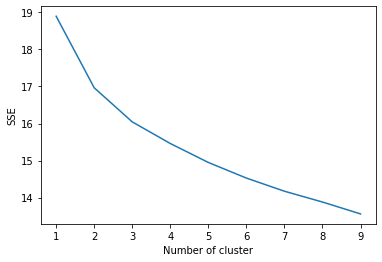

In [298]:
# Lets first choose a right value of k, using the Elbow Criterion Method
sse={}
for k in range(1,10):
    # run k-means clustering
    kmeans_loop = KMeans(init='k-means++',n_clusters=k, random_state=0,n_init=15).fit(Neighborhood_grouped_clustering)
    sse[k]=kmeans_loop.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

It seems somewhere around 3, there is an elbow, after  which the curve seems to follow the same slope

In [299]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(init='k-means++',n_clusters=kclusters, random_state=0,n_init=15).fit(Neighborhood_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 1, 1, 1, 1, 1, 0, 1, 2, 1])

In [300]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
for i in range(0,len(unique)):
    print('Label: {}, Count: {}'.format(unique[i],counts[i]))

Label: 0, Count: 76
Label: 1, Count: 237
Label: 2, Count: 169


This method provides good segregation. Thus we will go ahead with this method. 

Lets add clustering labels to our Datasets, and prepare them for analysis

In [301]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [302]:
Neighborhood_merged = Neighborhood

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Neighborhood_merged = Neighborhood_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

Neighborhood_merged.head() # check the last columns!

,Borough,Neighbourhood,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,1,40.894705,-73.847201,1.0,Pharmacy,Caribbean Restaurant,Fried Chicken Joint,Supermarket,Gas Station,Fast Food Restaurant,Donut Shop,Chinese Restaurant,Pizza Place,Bakery
1,Bronx,Co-op City,1,40.874294,-73.829939,1.0,Department Store,Pizza Place,Mobile Phone Shop,Chinese Restaurant,Shopping Mall,Shoe Store,Baseball Field,Bakery,Mexican Restaurant,Furniture / Home Store
2,Bronx,Eastchester,1,40.887556,-73.827806,1.0,Caribbean Restaurant,Shopping Mall,Fast Food Restaurant,Deli / Bodega,Diner,Asian Restaurant,Donut Shop,Supermarket,Sandwich Place,Supplement Shop
3,Bronx,Fieldston,1,40.895437,-73.905643,1.0,Bus Station,Pizza Place,Bar,Bank,Playground,Plaza,Deli / Bodega,Sandwich Place,Mexican Restaurant,General Eating
4,Bronx,Riverdale,1,40.890834,-73.912585,1.0,Pizza Place,Bank,Bar,Diner,Coffee Shop,Bagel Shop,Park,Plaza,Playground,Japanese Restaurant


In [303]:
print('Shape prior to dropping values: ',Neighborhood_merged.shape)
Neighborhood_merged.dropna(axis=0,inplace=True)
print('Shape after dropping values: ',Neighborhood_merged.shape)
Neighborhood_merged.head()

Shape prior to dropping values:  (489, 16)
Shape after dropping values:  (488, 16)


,Borough,Neighbourhood,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,1,40.894705,-73.847201,1.0,Pharmacy,Caribbean Restaurant,Fried Chicken Joint,Supermarket,Gas Station,Fast Food Restaurant,Donut Shop,Chinese Restaurant,Pizza Place,Bakery
1,Bronx,Co-op City,1,40.874294,-73.829939,1.0,Department Store,Pizza Place,Mobile Phone Shop,Chinese Restaurant,Shopping Mall,Shoe Store,Baseball Field,Bakery,Mexican Restaurant,Furniture / Home Store
2,Bronx,Eastchester,1,40.887556,-73.827806,1.0,Caribbean Restaurant,Shopping Mall,Fast Food Restaurant,Deli / Bodega,Diner,Asian Restaurant,Donut Shop,Supermarket,Sandwich Place,Supplement Shop
3,Bronx,Fieldston,1,40.895437,-73.905643,1.0,Bus Station,Pizza Place,Bar,Bank,Playground,Plaza,Deli / Bodega,Sandwich Place,Mexican Restaurant,General Eating
4,Bronx,Riverdale,1,40.890834,-73.912585,1.0,Pizza Place,Bank,Bar,Diner,Coffee Shop,Bagel Shop,Park,Plaza,Playground,Japanese Restaurant


Lets add clustering label to our grouped data frame. This dataframe contains the mean of presence of a Venue in a Neighborhood

In [305]:
Neighborhood_grouped_label=Neighborhood_grouped
Neighborhood_grouped_label=Neighborhood_grouped_label.join(neighborhoods_venues_sorted[['Neighbourhood','Cluster Labels']].set_index('Neighbourhood'), on='Neighbourhood')
Neighborhood_grouped_label.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,Alsatian Restaurant,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Cluster Labels
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,2
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1
4,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1


Lets add clustering label to our onehot dataframe. We will use this dataframe to find the mean & sum for a venue in each neighborhood. 

In [306]:
Neighborhood_onehot_label=Neighborhood_onehot
Neighborhood_onehot_label=Neighborhood_onehot_label.join(neighborhoods_venues_sorted[['Neighbourhood','Cluster Labels']].set_index('Neighbourhood'), on='Neighbourhood')

In [307]:
#Neighborhood_onehot_label.head()
Neighborhood_Cluster_Mean=Neighborhood_onehot_label.groupby('Cluster Labels').mean().reset_index()
Neighborhood_Cluster_Mean

,Cluster Labels,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,Alsatian Restaurant,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0,0.000400,0.000000,0.000000,0.001733,0.000000,0.000000,0.000000,0.000000,0.000133,...,0.000000,0.000000,0.021197,0.004133,0.000000,0.000133,0.002400,0.000533,0.000400,0.000533
1,1,0.000872,0.000000,0.000158,0.000713,0.000000,0.000000,0.000079,0.000079,0.000000,...,0.000317,0.000000,0.000634,0.002298,0.000000,0.002139,0.003011,0.001426,0.001030,0.000475
2,2,0.000679,0.000302,0.000226,0.000528,0.000151,0.000226,0.000452,0.000075,0.000000,...,0.000075,0.000905,0.008596,0.009953,0.000075,0.000905,0.002338,0.011160,0.000075,0.000000


In [308]:
Neighborhood_Cluster_Sum=Neighborhood_onehot_label.groupby('Cluster Labels').sum().reset_index()
Neighborhood_Cluster_Sum

,Cluster Labels,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,Alsatian Restaurant,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0,3.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,159.0,31.0,0.0,1.0,18.0,4.0,3.0,4.0
1,1,11.0,0.0,2.0,9.0,0.0,0.0,1.0,1.0,0.0,...,4.0,0.0,8.0,29.0,0.0,27.0,38.0,18.0,13.0,6.0
2,2,9.0,4.0,3.0,7.0,2.0,3.0,6.0,1.0,0.0,...,1.0,12.0,114.0,132.0,1.0,12.0,31.0,148.0,1.0,0.0


## Results: Cluster Analysis
##### Lets analyse the outcomes of the clustering process. Here we will focus on two things:
1. **How similar or disimilar are the three cities (NY, Toronto, Paris).** If people from one neighbourhood in a particular city, want to migrate into a different city, what are their choices for similar Neighbourhood. 
2. **Business opportunities in a particular neighbourhood.** If a businessman wants to open a new business (of a particular type/category), then which neighbourhood's are his options. 

#### 1. Lets evaluate how similar or disimilar are the three cities

In [309]:
print('All Neighbourhood Shape: ',Neighborhood_merged.shape)
Toronto_merged=Neighborhood_merged[Neighborhood_merged['City']==2]
print('Toronto: ',Toronto_merged.shape)
NY_merged=Neighborhood_merged[Neighborhood_merged['City']==1]
print('NY: ',NY_merged.shape)
Paris_merged=Neighborhood_merged[Neighborhood_merged['City']==3]
print('Paris: ',Paris_merged.shape)

All Neighbourhood Shape:  (488, 16)
Toronto:  (102, 16)
NY:  (306, 16)
Paris:  (80, 16)


In [310]:
legend_list=[]
small_legend=[]
for index, rows in pd.DataFrame(Neighborhood_merged['Cluster Labels'].value_counts().reset_index()).iterrows():
    legend_list.append('Cluster: {}, Neighbourhoods: {}'.format(rows[0],rows[1]))
    small_legend.append('Cluster: {}'.format(rows[0]))
    print(legend_list[index])

Cluster: 1.0, Neighbourhoods: 240.0
Cluster: 2.0, Neighbourhoods: 172.0
Cluster: 0.0, Neighbourhoods: 76.0


In [311]:
neighbourhood_segregation=pd.DataFrame(columns=['Cluster Label','New York','Toronto','Paris'])

for k in set(kmeans.labels_):
    ny_count=0
    toronto_count=0
    paris_count=0
    for index, rows in pd.DataFrame(Neighborhood_merged[Neighborhood_merged['Cluster Labels']==k]['City'].value_counts().reset_index()).iterrows():
        if rows[0]==1:
            ny_count=rows[1]
        elif rows[0]==2:
            toronto_count=rows[1]
        elif rows[0]==3:
            paris_count=rows[1]    
    neighbourhood_segregation = neighbourhood_segregation.append({'Cluster Label': k,
                                          'New York': ny_count,
                                          'Toronto': toronto_count,
                                          'Paris': paris_count}, ignore_index=True)
    
neighbourhood_segregation.set_index('Cluster Label',inplace=True)
neighbourhood_segregation.head()

,New York,Toronto,Paris
Cluster Label,,,
0,0,0,76
1,211,28,1
2,95,74,3


Lets see how the entire Neighbourhood dataset is clustered in a pie chart

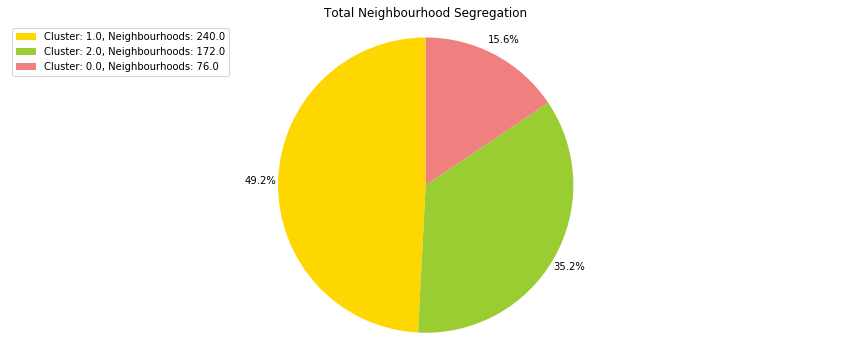

In [312]:
#legend_list=list(count.index)
colors_list = ['gold', 'yellowgreen', 'lightcoral']
Neighborhood_merged['Cluster Labels'].value_counts().plot(kind='pie',
                                                          figsize=(15,6),
                                                          labels=None, 
                                                          autopct='%1.1f%%', 
                                                          startangle=90,
                                                          shadow=False,
                                                          colors=colors_list,
                                                          pctdistance=1.12,subplots=True)
                                                          

plt.title('Total Neighbourhood Segregation')
plt.ylabel('')
plt.axis('equal')
plt.legend(labels=legend_list,loc='upper left')

plt.show()

Lets see the the spread of each city in a cluster

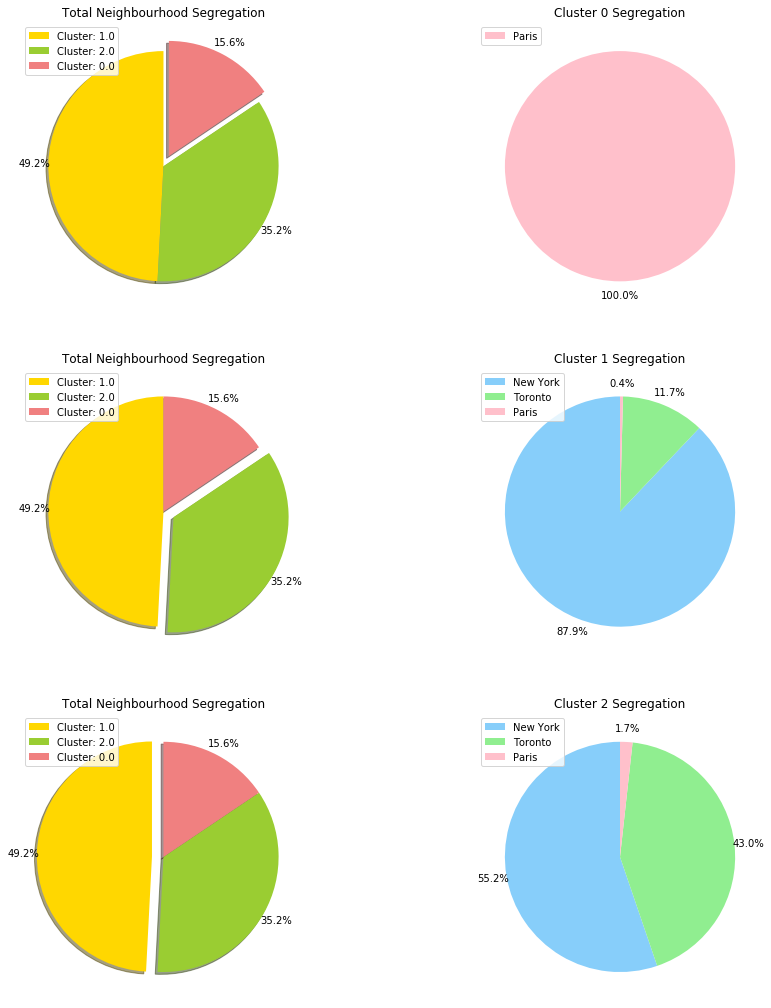

In [313]:
fig = plt.figure()
ax0 = fig.add_subplot(3, 2, 5) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(3, 2, 6) # add subplot 2 (1 row, 2 columns, second plot)
ax2 = fig.add_subplot(3, 2, 3) # add subplot 1 (1 row, 2 columns, first plot)
ax3 = fig.add_subplot(3, 2, 4) # add subplot 2 (1 row, 2 columns, second plot)
ax4 = fig.add_subplot(3, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax5 = fig.add_subplot(3, 2, 2) # add subplot 2 (1 row, 2 columns, second plot)

figuresize=(15,18)
explode_list_ax0=[0.1,0,0]
colors_list_ax0 = ['gold', 'yellowgreen', 'lightcoral']
colors_list_ax1 = ['lightskyblue', 'lightgreen', 'pink']
Neighborhood_merged['Cluster Labels'].value_counts().plot(kind='pie',
                                                          figsize=figuresize,
                                                          labels=None, 
                                                          autopct='%1.1f%%', 
                                                          startangle=90,
                                                          shadow=True,
                                                          colors=colors_list_ax0,
                                                          pctdistance=1.12,
                                                          explode=explode_list_ax0, ax=ax0)
ax0.legend(labels=small_legend,loc='upper left')
ax0.set_title('Total Neighbourhood Segregation')
ax0.set_ylabel('')

Neighborhood_merged[Neighborhood_merged['Cluster Labels']==2]['City'].value_counts().plot(kind='pie',
                                                          figsize=figuresize,
                                                          labels=None, 
                                                          autopct='%1.1f%%', 
                                                          startangle=90,
                                                          shadow=False,
                                                          colors=colors_list_ax1,
                                                          pctdistance=1.12, ax=ax1)
                                                          #explode=explode_list
ax1.set_title('Cluster 2 Segregation')
ax1.legend(labels=['New York','Toronto','Paris'],loc='upper left')
ax1.set_ylabel('')

explode_list_ax2=[0.0,0.1,0]
Neighborhood_merged['Cluster Labels'].value_counts().plot(kind='pie',
                                                          figsize=figuresize,
                                                          labels=None, 
                                                          autopct='%1.1f%%', 
                                                          startangle=90,
                                                          shadow=True,
                                                          colors=colors_list_ax0,
                                                          pctdistance=1.12,
                                                          explode=explode_list_ax2, ax=ax2)
ax2.legend(labels=small_legend,loc='upper left')
ax2.set_title('Total Neighbourhood Segregation')
ax2.set_ylabel('')

Neighborhood_merged[Neighborhood_merged['Cluster Labels']==1]['City'].value_counts().plot(kind='pie',
                                                          figsize=figuresize,
                                                          labels=None, 
                                                          autopct='%1.1f%%', 
                                                          startangle=90,
                                                          shadow=False,
                                                          colors=colors_list_ax1,
                                                          pctdistance=1.12, ax=ax3)
                                                          #explode=explode_list
ax3.set_title('Cluster 1 Segregation')
ax3.legend(labels=['New York','Toronto','Paris'],loc='upper left')
ax3.set_ylabel('')

explode_list_ax4=[0.0,0,0.1]
colors_list_ax5 = ['pink']
Neighborhood_merged['Cluster Labels'].value_counts().plot(kind='pie',
                                                          figsize=figuresize,
                                                          labels=None, 
                                                          autopct='%1.1f%%', 
                                                          startangle=90,
                                                          shadow=True,
                                                          colors=colors_list_ax0,
                                                          pctdistance=1.12,
                                                          explode=explode_list_ax4, ax=ax4)
ax4.legend(labels=small_legend,loc='upper left')
ax4.set_title('Total Neighbourhood Segregation')
ax4.set_ylabel('')

Neighborhood_merged[Neighborhood_merged['Cluster Labels']==0]['City'].value_counts().plot(kind='pie',
                                                          figsize=figuresize,
                                                          labels=None, 
                                                          autopct='%1.1f%%', 
                                                          startangle=90,
                                                          shadow=False,
                                                          colors=colors_list_ax5,
                                                          pctdistance=1.12, ax=ax5)
                                                          #explode=explode_list
ax5.set_title('Cluster 0 Segregation')
ax5.legend(labels=['Paris'],loc='upper left')
ax5.set_ylabel('')

plt.show()

**Similarity or Dissimilarity**:
1. It seems New York & Toronto are much similar to each other (the entire neighbourhood is majorly clustered into two clusters, namely 1 & 2). 
2. Paris seems to be different from both New York & Toronto (as it is clustered, almost entirely into cluster 0).
3. There are few neighbourhoods in Paris which are like the neighbourhoods of New York & Toronto (cluster 1 & 2).

**Lets try to visualize the clustered neighborhoods information on a Map**

**New York Map**

In [458]:
# create map
NY_clusters = folium.Map(location=[40.7128,-74.0060], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#print(colors_array)
print(rainbow)
# add markers to the map
markers_colors = []
for lat, lon, bor, neigh, cluster in zip(NY_merged['Latitude'], NY_merged['Longitude'], NY_merged['Borough'], NY_merged['Neighbourhood'], NY_merged['Cluster Labels']):
    #print(cluster)
    label = folium.Popup(str(bor) + ', ' + str(neigh)+ ', ' + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(NY_clusters)
       
NY_clusters

**Toronto Map**

In [315]:
# create map
Toronto_clusters = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, bor, neigh, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Borough'], Toronto_merged['Neighbourhood'], Toronto_merged['Cluster Labels']):
    #print(cluster)
    label = folium.Popup(str(bor) + ', ' + str(neigh)+ ', ' + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(Toronto_clusters)
       
Toronto_clusters

**Paris Map**

In [463]:
# create map
Paris_clusters = folium.Map(location=[48.8566,2.3522], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, bor, neigh, cluster in zip(Paris_merged['Latitude'], Paris_merged['Longitude'], Paris_merged['Borough'], Paris_merged['Neighbourhood'], Paris_merged['Cluster Labels']):
    #print(cluster)
    label = folium.Popup(str(bor) + ', ' + str(neigh)+ ', ' + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(Paris_clusters)
       
Paris_clusters

#### We present the dataset "Neighborhood_merged", as a similarity/dissimilarity matrix for our report

In [464]:
Neighborhood_merged.head()

,Borough,Neighbourhood,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,1,40.894705,-73.847201,1.0,Pharmacy,Caribbean Restaurant,Fried Chicken Joint,Supermarket,Gas Station,Fast Food Restaurant,Donut Shop,Chinese Restaurant,Pizza Place,Bakery
1,Bronx,Co-op City,1,40.874294,-73.829939,1.0,Department Store,Pizza Place,Mobile Phone Shop,Chinese Restaurant,Shopping Mall,Shoe Store,Baseball Field,Bakery,Mexican Restaurant,Furniture / Home Store
2,Bronx,Eastchester,1,40.887556,-73.827806,1.0,Caribbean Restaurant,Shopping Mall,Fast Food Restaurant,Deli / Bodega,Diner,Asian Restaurant,Donut Shop,Supermarket,Sandwich Place,Supplement Shop
3,Bronx,Fieldston,1,40.895437,-73.905643,1.0,Bus Station,Pizza Place,Bar,Bank,Playground,Plaza,Deli / Bodega,Sandwich Place,Mexican Restaurant,General Eating
4,Bronx,Riverdale,1,40.890834,-73.912585,1.0,Pizza Place,Bank,Bar,Diner,Coffee Shop,Bagel Shop,Park,Plaza,Playground,Japanese Restaurant


#### 2. Business opportunities in a particular neighbourhood

In [460]:
Neighborhood_Cluster_Sum.set_index('Cluster Labels',inplace=True)
Neighborhood_Cluster_Sum.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,Alsatian Restaurant,American Restaurant,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
Cluster Labels,,,,,,,,,,,,,,,,,,,,,
0,3.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,1.0,17.0,...,0.0,0.0,159.0,31.0,0.0,1.0,18.0,4.0,3.0,4.0
1,11.0,0.0,2.0,9.0,0.0,0.0,1.0,1.0,0.0,144.0,...,4.0,0.0,8.0,29.0,0.0,27.0,38.0,18.0,13.0,6.0
2,9.0,4.0,3.0,7.0,2.0,3.0,6.0,1.0,0.0,222.0,...,1.0,12.0,114.0,132.0,1.0,12.0,31.0,148.0,1.0,0.0


The idea here is to present the 30 most popular businesses in each neighbourhood cluster, through a word cloud

In [351]:
#Lets get a word string for each neighbourhood cluster
word_list=[]
for k in Neighborhood_Cluster_Sum.index.values:
    word_string={}
    for value in Neighborhood_Cluster_Sum.columns[:-1]:
        word_string[''.join(value.split())]=Neighborhood_Cluster_Sum.loc[k,value]
    word_list.append(word_string)
len(word_list)

3

In [359]:
#Lets set the max words to 30, as we want to show the top 30 businesses
max_words1=30 

#### Cluster 0

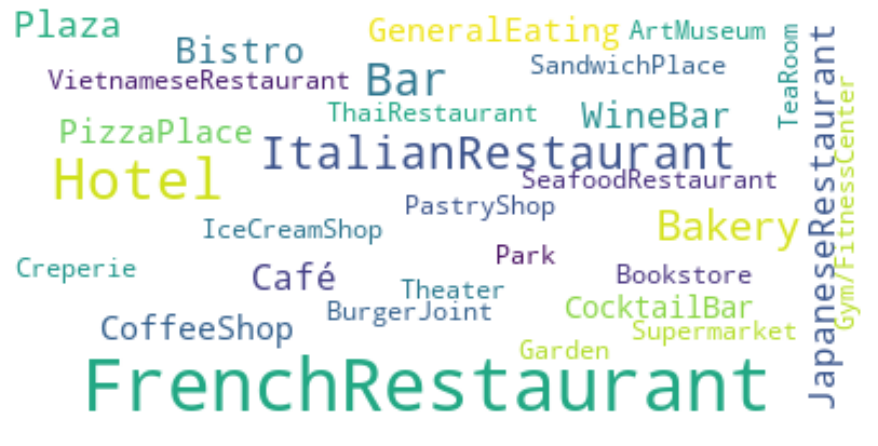

In [360]:
wordcloud = WordCloud(background_color='white',max_words=max_words1,collocations=False,relative_scaling=0.5).generate_from_frequencies(word_list[0])
# display the cloud
fig = plt.figure(figsize=(20,6))
# fig.set_figwidth(14)
# fig.set_figheight(22)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### Cluster 1

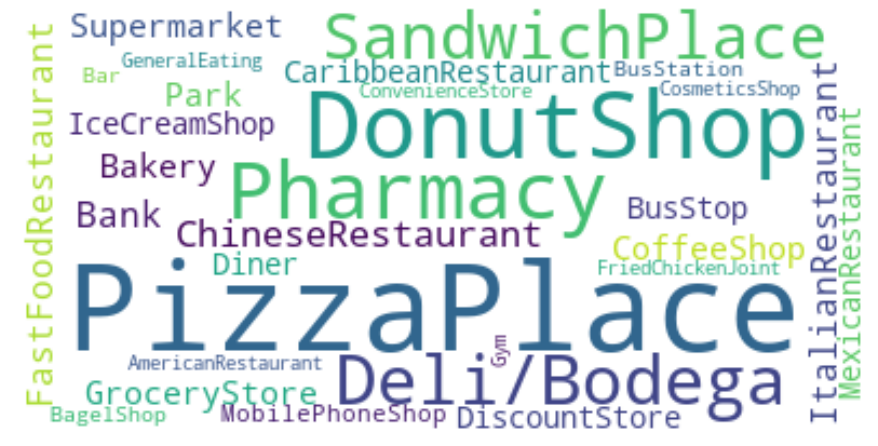

In [361]:
#wordcloud = WordCloud(background_color='white',max_words=max_words1,collocations=False,relative_scaling=0.5).generate(word_list[1])
wordcloud = WordCloud(background_color='white',max_words=max_words1,collocations=False,relative_scaling=0.5).generate_from_frequencies(word_list[1])
# display the cloud
fig = plt.figure(figsize=(20,6))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### Cluster 2

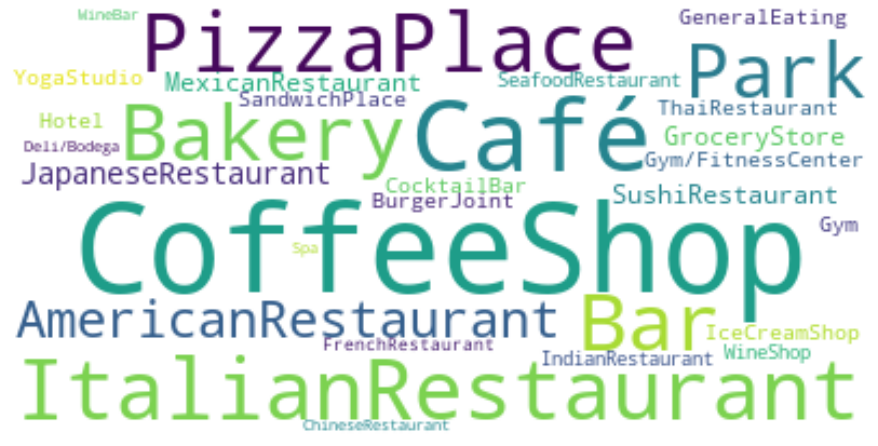

In [363]:
#wordcloud = WordCloud(background_color='white',max_words=max_words1,collocations=False,relative_scaling=0.5).generate(word_list[2])
wordcloud = WordCloud(background_color='white',max_words=max_words1,collocations=False,relative_scaling=0.5).generate_from_frequencies(word_list[2])
# display the cloud
fig = plt.figure(figsize=(20,6))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Basis for our opportunity matrix:
For a venue category in a cluster, if the **neighbourhood mean** is **much** less than the **neighbourhood cluster mean**, then there is an opportunity to grow the business in that particular neighbourhood
Lets try to compare the means. 
**For our report**:
1. We will compare the top 30 venues in each neighbourhood
2. If the **neighbourhood mean** is **less than half** of the **neighbourhood cluster mean**, then we will present that as an opportunity to grow the business in that neighbourhood

In [213]:
Neighborhood_Cluster_Mean=Neighborhood_Cluster_Mean.set_index('Cluster Labels')
Neighborhood_Cluster_Mean.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,Alsatian Restaurant,American Restaurant,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
Cluster Labels,,,,,,,,,,,,,,,,,,,,,
0,0.000400,0.000000,0.000000,0.001733,0.000000,0.000000,0.000000,0.000000,0.000133,0.002266,...,0.000000,0.000000,0.021197,0.004133,0.000000,0.000133,0.002400,0.000533,0.000400,0.000533
1,0.000872,0.000000,0.000158,0.000713,0.000000,0.000000,0.000079,0.000079,0.000000,0.011410,...,0.000317,0.000000,0.000634,0.002298,0.000000,0.002139,0.003011,0.001426,0.001030,0.000475
2,0.000679,0.000302,0.000226,0.000528,0.000151,0.000226,0.000452,0.000075,0.000000,0.016740,...,0.000075,0.000905,0.008596,0.009953,0.000075,0.000905,0.002338,0.011160,0.000075,0.000000


In [477]:
Neighborhood_Cluster_Mean.loc[1,'Accessories Store']

0.0008715632675699231

In [481]:
num_venues_to_extract=30
venue_occurence_highest={}
mean_columns_list=Neighborhood_Cluster_Mean.columns
mean_columns_list=mean_columns_list[1:]

for k in Neighborhood_Cluster_Mean.index.values:
    venue_cluster_topx=[]
    rows=Neighborhood_Cluster_Mean.loc[k,mean_columns_list]
    rows=rows.sort_values(ascending=False)
    venue_occurence_highest[k]=rows.index[0:num_venues_to_extract]

#venue_occurence_highest

In [483]:
Neighbourhood_Opp_List=[]
for key,values in venue_occurence_highest.items():
    cluster_mean=Neighborhood_Cluster_Mean.loc[key,values].to_numpy()
    condition=Neighborhood_grouped_label['Cluster Labels']==key
    temp_df=Neighborhood_grouped_label[condition][['Neighbourhood'] + list(values)]
    for index, rows in temp_df.iterrows():
        # Get the Neighbourhood details from Neighbourhood locations
        neigh=Neighborhood.loc[Neighborhood['Neighbourhood']==rows[0],['Borough','City']]
        for i in range(1,temp_df.shape[1]):
            opportunity=((cluster_mean[i-1] * 2)/4)
            inner_list=[]
            if rows[i]<opportunity:
                inner_list.append(neigh.values[0][0]) # Borough
                inner_list.append(rows[0]) # Neighbourhood
                inner_list.append(neigh.values[0][1]) # City Indicator
                inner_list.append(temp_df.columns[i]) # Venue Category
                inner_list.append(i) # Venue Rank
                inner_list.append(rows[i]) # Neighbourhood Mean
                inner_list.append(cluster_mean[i-1]) # Neighbourhood Cluster Mean
                inner_list.append(opportunity - rows[i]) # Opportunity 
                inner_list.append(key) # Cluster Label
                Neighbourhood_Opp_List.append(inner_list)

In [484]:
Neighbourhood_Opportunities=pd.DataFrame(Neighbourhood_Opp_List,columns=['Borough','Neighbourhood','City','Venue Category','Venue Rank','Neighbourhood Mean','Cluster Mean','Opportunity','Cluster Label'])
Neighbourhood_Opportunities=Neighbourhood_Opportunities.sort_values(by=['Cluster Label','Venue Rank','Venue Category'])
Neighbourhood_Opportunities.head()

,Borough,Neighbourhood,City,Venue Category,Venue Rank,Neighbourhood Mean,Cluster Mean,Opportunity,Cluster Label
137,"9th arrondissement(Called ""de l'Opéra"")",Chaussée-d'Antin,3,French Restaurant,1,0.050000,0.135449,0.017724,0
340,"18th arrondissement(Called ""des Buttes-Montmar...",La Chapelle,3,French Restaurant,1,0.066667,0.135449,0.001058,0
402,"19th arrondissement(Called ""des Buttes-Chaumont"")",La Villette,3,French Restaurant,1,0.060000,0.135449,0.007724,0
532,"14th arrondissement(Called ""de l'Observatoire"")",Parc Montsouris,3,French Restaurant,1,0.042105,0.135449,0.025619,0
0,"19th arrondissement(Called ""des Buttes-Chaumont"")",Amérique,3,Hotel,2,0.030000,0.068391,0.004195,0


In [485]:
print('There are {} identified opportunities'.format(Neighbourhood_Opportunities.shape[0]))

There are 6838 identified opportunities


#### We present the above dataset "Neighbourhood_Opportunities", as a business opportunities matrix for our report
**Some important fields to consider in the dataset**:
1. Venue Category: The Business that we are talking about
2. Venue Rank: Popularity ranking of a business, in a cluster neighbourhood
3. Opportunity: The difference between neighbourhood cluster mean (divided by two) and neighbourhood mean for a particular Venue Category. The higher the value, the better chance of the business succeeding
